<a href="https://colab.research.google.com/github/androbaza/IP-algos/blob/main/InverseFiltering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from imageio import imread
import matplotlib.pyplot as plt

from skimage.transform import resize

from scipy.fftpack import fft2, ifft2, fftshift, ifftshift

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


(512, 512)


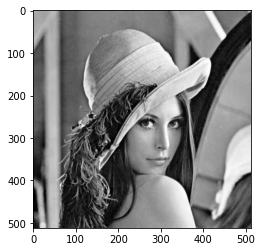

In [3]:
im = imread("/content/drive/MyDrive/samples/lena.jpg", pilmode="L")

plt.imshow(im, cmap="gray")
print(im.shape)
plt.show()

In [4]:
def DFT(im, shift=False):
    """
        Transforms an image to Fourier domain 
    """
    
    if im.dtype == np.uint8:
        im = im.astype(np.float) / 255
    
    I = fft2(im)
    if shift:
        I = fftshift(I)
    
    return I


def maskDFT(mask, size, shift=False):
    """
        Transforms a filter mask to Fourier domain, 
        padded to the given size
    """
    
    h, w = size
    f_h, f_w = mask.shape
    d_h, d_w = h - f_h, w - f_w
    
    padding =[
        (
            int(np.ceil(d_h / 2)),
            int(np.floor(d_h / 2)),
        ), (
            int(np.ceil(d_w / 2)),
            int(np.floor(d_w / 2)),
        )
    ]
    mask = fftshift(np.pad(mask, padding, mode="constant"))
    
    return DFT(mask, shift=shift)


def iDFT(I, shift=False):
    """
        Transforms an image back from Fourier to spatial domain 
    """
    
    if shift:
        I = ifftshift(I)
    
    im = ifft2(I).real
    
    return im

# Exercise 5: Inverse Filtering

Use the functions above to implement inverse filtering!
Think about the following in advance:

1. How to model different degradation processes? Implement functions, that apply motion or atmospheric blur to an input image!
2. How to model a noise process? Implement a function, that applies Gaussian noise to an input image!
3. Create from an image a (1) *degraded image* and (2) a *degraded image with noise*. Visualize the resulting images and the degradation filters!
4. Now implement a function, that applies inverse filtering based on an image and a degradation filter (represented in Frequency Domain!). Use this function to restore the (1) *degraded image* and the (2) *degraded image with noise* from previous step. Visualize the results!
5. What can be seen? Try out different noise strength and interpret the results!

## Degradation Processes

In [5]:
def gaussian(size, sigma=1):
    """ Creates gaussian kernel with a given size and sigma (in spatial domain). """
    ax = np.arange(np.ceil(-size / 2), np.ceil(size / 2))
    xx, yy = np.meshgrid(ax, ax)

    kernel = np.exp(-(xx**2 + yy**2) / (2. * sigma**2))

    return kernel / kernel.sum()


def motion(size, identity=False):
    if identity:
        return np.identity(size, dtype=int)
    a = np.zeros((size, size), dtype=np.int)
    a[:, int(size/2)] =  1
    return a


def box(size):
    # TODO: create box filter!
    return 1/(size**2) * np.ones((size, size), dtype=np.int)

In [6]:
def degrade(im, mask):
    imF = DFT(im, True)
    H = maskDFT(mask, im.shape, True)
    res = iDFT(imF * H, True)
    # return the result and the mask in fourier domain
    return res, H

In [7]:
def noise(im, strength=0.1):
    # TODO: create random gaussian noise based on 
    # the strength parameter and maximum pixel value of the image
    gaussian = np.random.normal(0, strength, (im.shape[0],im.shape[1])) 
    
    noisy = np.clip(im + gaussian, 0, 255)
    return noisy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecat

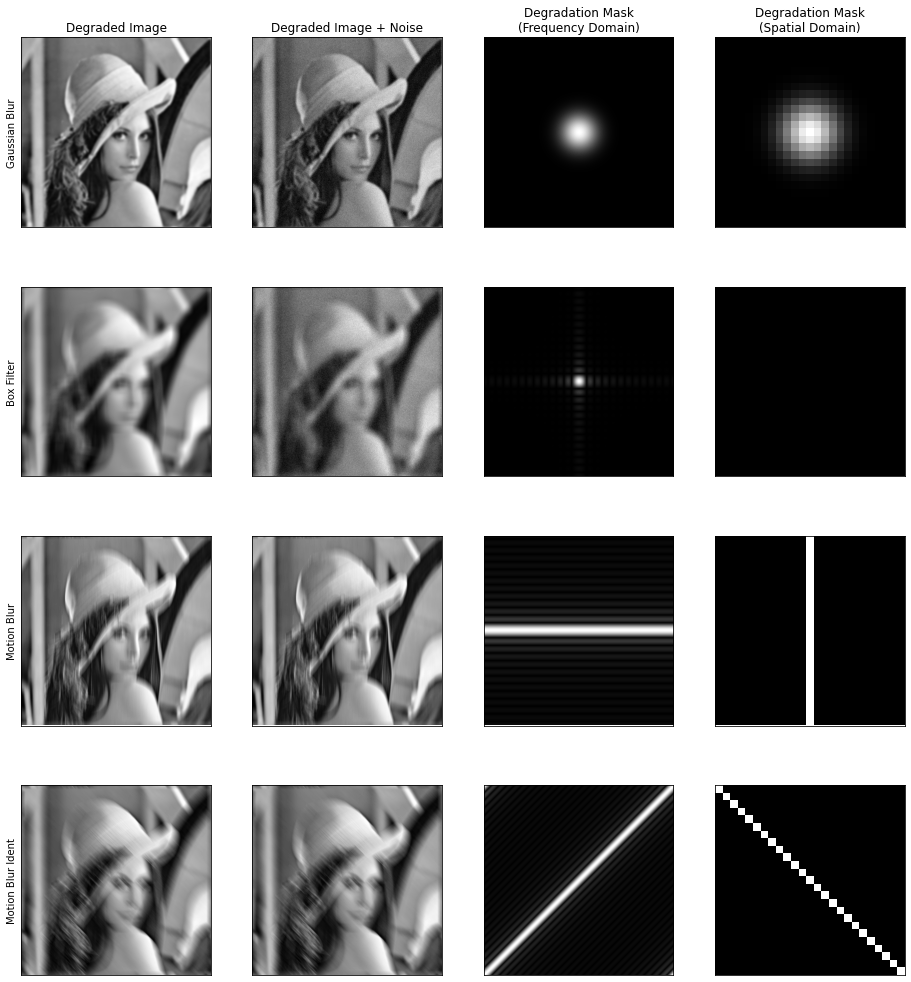

In [8]:
### Create degradation masks ###

size = int(max(im.shape) * 0.05)

# Set of filters (filter_name, mask)
filters = [
    ('Gaussian Blur', gaussian(size=size, sigma=np.sqrt(size)*0.5)),
    ('Box Filter', box(size)),
    ('Motion Blur', motion(size)),
    ('Motion Blur Ident', motion(size, True)),
]

### Apply the degradation ###
degraded = [degrade(im, mask) for name, mask in filters]

### Add noise ###
noisy = [noise(deg, 0.05) for deg, _ in degraded]

### Visualize results ###
fig, axs = plt.subplots(len(degraded), 4, figsize=(13, 3.5*len(degraded)))
fig.tight_layout()
for ax in axs.ravel():
    ax.tick_params(labelleft=False, labelbottom=False, left=False, bottom=False)

axs[0, 0].set_title("Degraded Image")
axs[0, 1].set_title("Degraded Image + Noise")
axs[0, 2].set_title("Degradation Mask\n(Frequency Domain)")
axs[0, 3].set_title("Degradation Mask\n(Spatial Domain)")

for ax, (im_deg, H), im_noisy, (name, filter) in zip(axs, degraded, noisy, filters):
    ax[0].set_ylabel(name)
    ax[0].imshow(im_deg, cmap=plt.cm.gray)
    ax[1].imshow(im_noisy, cmap=plt.cm.gray)
    ax[2].imshow(np.abs(H), cmap=plt.cm.gray)  # TODO: visualize the mask in frequency domain
    ax[3].imshow(filter, cmap=plt.cm.gray)  # TODO: visualize the mask in spatial domain

plt.show()

## Inverse Filtering

In [9]:
def inverse_filter(im, mask, eps=1e-6):
    """ Applies inverse filtering to a degraded image.
    
    im - The degraded image.
    mask - The filter mask in the frequency domain.
    eps - Entries of the filter mask in range [-eps, eps] will
          be ignored to avoid over-amplification of noise effects.
    """
    mask[np.abs(mask)<=eps] = eps
    # TODO: implement inverse filtering algorithm
    # hint: use eps for computational stability!
    res = iDFT(DFT(im, True) / mask)
    return np.abs(res)

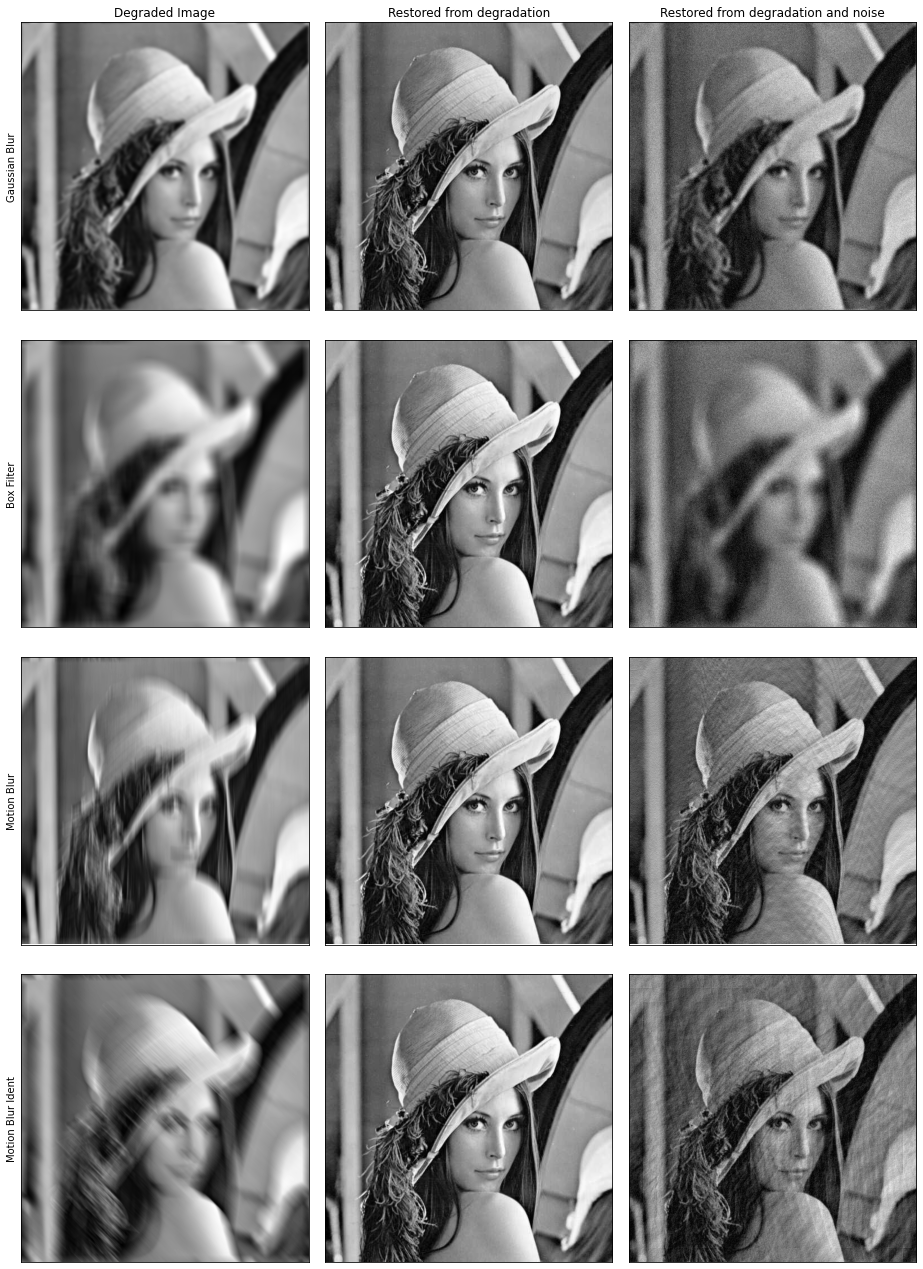

In [10]:
# Apply inverse filtering to degraded images
restored = [inverse_filter(im_deg, H) for im_deg, H in degraded]
# Apply inverse filtering to degraded images with noise
restored_noisy = [inverse_filter(im_noisy, H, eps=8e-1) for im_noisy, (_, H) in zip(noisy, degraded)]

# Visualize results
fig, axs = plt.subplots(len(degraded), 3, figsize=(13, 4.5*len(degraded)))
for ax in axs.ravel():
    ax.tick_params(labelleft=False, labelbottom=False, left=False, bottom=False)

axs[0, 0].set_title("Degraded Image")
axs[0, 1].set_title("Restored from degradation")
axs[0, 2].set_title("Restored from degradation and noise")

for ax, (deg, _), rest, rest_noisy, (name, _) in zip(axs, degraded, restored, restored_noisy, filters):
    ax[0].set_ylabel(name)
    ax[0].imshow(deg, cmap=plt.cm.gray)
    ax[1].imshow(rest, cmap=plt.cm.gray)
    ax[2].imshow(rest_noisy, cmap=plt.cm.gray)

fig.tight_layout()
plt.show()

inverse filtering works very well for noiseless distortions of images, while certain level of noise introduced forces to use higher eps for the image to become more usable, but at the cost if introducing artefacts.